
# Рынок заведений общественного питания Москвы


Цель исследования: анализ текущего состояния рынка общественного питания города Москва для оценки потенциала открытия нового бизнеса.   
В рамках исследования мы изучим какой тип объекта общественного питания наиболее распространен в Москве и какая форма (сетевое/несетевой заведение). Определим сколько посадочных мест потребуется и какой район будет наиболее перспективным для нового заведения.

**Этапы исследования:**

1. Обзор данных
2. Предобработка данных
3. Анализ данных
4. Общий вывод и рекомендации

<a name="h1"></a>
### 1. Обзор данных

#### Импорт библиотек

In [1]:
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

import numpy as np

import scipy.stats as stats

from io import BytesIO
import requests

#### Настройка

In [2]:
#отображение данных до двух знаков после запятой
pd.set_option('display.precision', 2)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.options.display.max_colwidth = 100

#### Анализ файла

In [3]:
rest_data = pd.read_csv('/datasets/rest_data.csv')

In [4]:
rest_data.head()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


In [5]:
rest_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


**Вывод**  
Представлена информация о 15 366 заведениях общественного питания г. Москва. Типы данных корректны, пропуски не обнаружены. Для дальнейшего анализа убедимся, что дубликаты отсутствуют и приведем данные в столбцах `object_name` и `address` к нижнему регистру, чтобы избежать возможного задваивания наименований.

<a name="h2"></a>
### 2. Предобработка данных

Проверим данные на наличие дубликатов.

In [6]:
rest_data['id'].duplicated().sum()

0

In [7]:
rest_data['object_type'].unique()

array(['кафе', 'столовая', 'закусочная',
       'предприятие быстрого обслуживания', 'ресторан', 'кафетерий',
       'буфет', 'бар', 'магазин (отдел кулинарии)'], dtype=object)

Приведем к нижнему регистру названия заведений и адреса.

In [8]:
rest_data['object_name'] = rest_data['object_name'].str.lower()

In [9]:
rest_data['address'] = rest_data['address'].str.lower()

Избавимся от кавычек в названиях заведений.

In [10]:
rest_data['object_name'] = rest_data['object_name'].str.replace('«', '')
rest_data['object_name'] = rest_data['object_name'].str.replace('»', '')

In [11]:
rest_data.head()

,id,object_name,chain,object_type,address,number
0,151635,сметана,нет,кафе,"город москва, улица егора абакумова, дом 9",48
1,77874,родник,нет,кафе,"город москва, улица талалихина, дом 2/1, корпус 1",35
2,24309,кафе академия,нет,кафе,"город москва, абельмановская улица, дом 6",95
3,21894,пиццетория,да,кафе,"город москва, абрамцевская улица, дом 1",40
4,119365,кафе вишневая метель,нет,кафе,"город москва, абрамцевская улица, дом 9, корпус 1",50


**Вывод**  
Дубликаты в строках и в столбце `object_type` не обнаружены. Названия заведений общественного питания и адреса приведены к нижнему регистру и избавлены от кавычек во избежание задваивания наименований.

<a name="h3"></a>
### 3. Анализ данных

Исследуем **соотношение видов объектов общественного питания по количеству**.

In [12]:
# группируем данные по виду объекта общественного питания
q_object_type = rest_data.groupby('object_type').agg({'id': 'nunique', 'number': 'mean'}).reset_index()

In [13]:
q_object_type.columns = ['object_type', 'number_of_objects', 'number_of_seats']

In [14]:
q_object_type.sort_values('number_of_objects', ascending=False)

,object_type,number_of_objects,number_of_seats
3,кафе,6099,39.72
8,столовая,2587,130.25
7,ресторан,2285,96.83
6,предприятие быстрого обслуживания,1923,20.55
0,бар,856,43.49
1,буфет,585,51.13
4,кафетерий,398,9.12
2,закусочная,360,7.61
5,магазин (отдел кулинарии),273,5.59


In [15]:
#напишем функцию для создания графиков типа sns.barplot
def sns_barplot(x, y, data):
    plt.figure(figsize=(16,8))
    ax = sns.barplot(x=x, y=y, data=data.sort_values(y, ascending=False), palette=sns.color_palette("BuPu", 10))
    #ax.grid(b=True, which='major', color='#d3d3d3', linewidth=1.0)

    for p in ax.patches:
        height = p.get_height()
        if np.isnan(height):
            height = 0
        ax.text(p.get_x() + p.get_width()/2., height, '%d' % int(height), 
            fontsize=11, color='black', ha='center', va='bottom')
    
    plt.xticks(rotation=45)

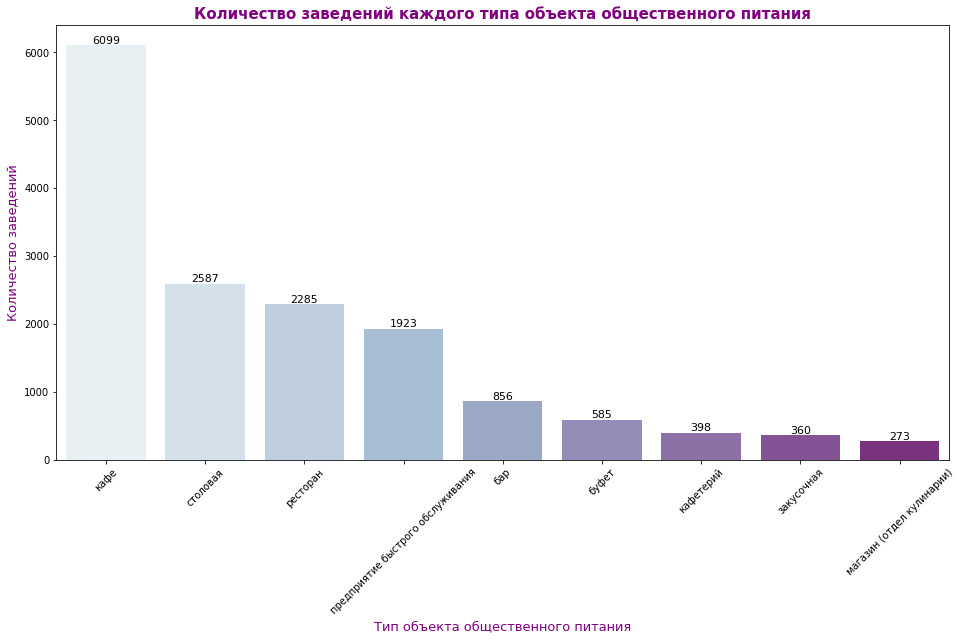

In [16]:
#отразим на графике количество заведений каждого типа объекта общественного питания
sns_barplot('object_type', 'number_of_objects', q_object_type)

plt.title("Количество заведений каждого типа объекта общественного питания", fontsize = 15, fontweight="bold", color='purple')
plt.xlabel("Тип объекта общественного питания", fontsize = 13, fontweight=500,color='purple')
plt.ylabel('Количество заведений', fontsize = 13, fontweight=500,color='purple')
plt.show();

**Вывод**  
С большим отрывом по количеству заведений лидируют кафе. Скорее всего это обусловлено тем, что они представляют собой золотую середину: они имеют не такой ограниченный ассортимент, как предприятия быстрого обслуживания, бар, буфет, кафетерий или закусочная; находятся в более доступном, с точки зрения частоты посещения, ценовом сегменте, в отличие от ресторанов, но при этом класс обслуживания в них выше, чем в столовых.   
Разновидностей кафе гораздо больше, чем других заведений. По тематике и оформлению интерьера: детские, студенческие, молодежные, корпоративные, арт-кафе. По времени функционирования: постоянные и сезонные (летние кафе). По методу обслуживания: с официантами, самообслуживание через линию раздачи, фуршетный стол, салат-бар.  Кафе могут открываться практически везде: гостиницы, кинотеатры, музеи, театры, торговые и развлекательные центры, парки отдыха, места массовых гуляний (выездное обслуживание), мобильные кафе и уличные.  
Такая гибкость открывает множество путей для развития бизнеса и делает его привлекательным.

Исследуем **соотношение сетевых и несетевых заведений по количеству**.

In [17]:
# группируем данные по виду объекта общественного питания и отношению к сетевым/несетевым заведениям
q_chain_object_type = rest_data.groupby(['object_type', 'chain']).agg({'id': 'nunique'}).reset_index()

In [18]:
q_chain_object_type

,object_type,chain,id
0,бар,да,37
1,бар,нет,819
2,буфет,да,11
3,буфет,нет,574
4,закусочная,да,56
5,закусочная,нет,304
6,кафе,да,1396
7,кафе,нет,4703
8,кафетерий,да,52
9,кафетерий,нет,346


In [19]:
#создазим отдельные датафремы по сетевым и несетевым заведениям
q_chain_object_type_yes = q_chain_object_type[q_chain_object_type['chain'] == 'да'][['object_type', 'id']]
q_chain_object_type_yes.columns = ['object_type', 'chain']

In [20]:
q_chain_object_type_no = q_chain_object_type[q_chain_object_type['chain'] == 'нет'][['object_type', 'id']]
q_chain_object_type_no.columns = ['object_type', 'no_chain']

In [21]:
#объединим данные в один датафрейм
q_chain_object_type_all = q_chain_object_type_yes.merge(q_chain_object_type_no,on='object_type')

In [22]:
#рассчитаем для каждого типа объекта общественного питания долю сетевых и несетевых заведений
q_chain_object_type_all['chain_part'] = q_chain_object_type_all['chain'] * 100 / (q_chain_object_type_all['chain'] + 
                                                                            q_chain_object_type_all['no_chain']) 

In [23]:
q_chain_object_type_all['no_chain_part'] = q_chain_object_type_all['no_chain'] * 100 / (q_chain_object_type_all['chain'] + 
                                                                            q_chain_object_type_all['no_chain'])

In [24]:
q_chain_object_type_all

,object_type,chain,no_chain,chain_part,no_chain_part
0,бар,37,819,4.32,95.68
1,буфет,11,574,1.88,98.12
2,закусочная,56,304,15.56,84.44
3,кафе,1396,4703,22.89,77.11
4,кафетерий,52,346,13.07,86.93
5,магазин (отдел кулинарии),78,195,28.57,71.43
6,предприятие быстрого обслуживания,791,1132,41.13,58.87
7,ресторан,544,1741,23.81,76.19
8,столовая,3,2584,0.12,99.88


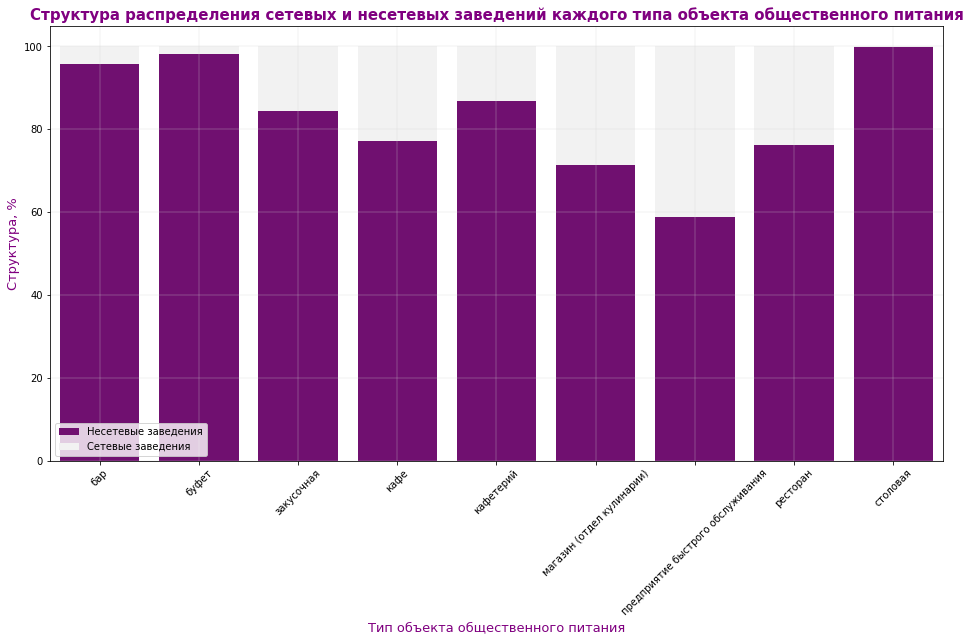

In [25]:
#основные параметры графика
plt.figure(figsize=(16,8))

#несетвые
ax = sns.barplot(x='object_type', y="no_chain_part", data=q_chain_object_type_all, 
                 color='purple', label="Несетевые заведения")
ax.grid(b=True, which='major', color='#d3d3d3', linewidth=0.3)

#сетвые
ax1 = sns.barplot(x='object_type', y="chain_part", data=q_chain_object_type_all, 
                 bottom=[i for i in q_chain_object_type_all['no_chain_part']], palette=sns.light_palette("grey", 1), 
                  label="Сетевые заведения")
ax1.grid(b=True, which='major', color='#d3d3d3', linewidth=0.3)

#заголовок графика и подписи осей    
plt.xticks(rotation=45)
plt.title("Структура распределения сетевых и несетевых заведений каждого типа объекта общественного питания", 
          fontsize = 15, fontweight="bold", color='purple')
plt.xlabel("Тип объекта общественного питания", fontsize = 13, fontweight=500,color='purple')
plt.ylabel('Структура, %', fontsize = 13, fontweight=500,color='purple')
plt.legend()
plt.show();

**Вывод**  
Несетевых заведений гораздо больше, чем сетевых, при этом сетевое распространение наиболее характерно для предприятий быстрого обслуживания. Это обусловлено распространенностью франчайзинга для такого вида объектов общественного питания. Возможность приобрести бизнес «под ключ» да еще и под узнаваемым брендом – заманчивая идея для большинства предпринимателей, что способствует активному росту сети.

Изучим, **что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест**?

In [26]:
#создадим датафрейм только с сетевыми заведениями и сгруппируем данные по наименованию
rest_data_chain = rest_data[rest_data['chain'] == 'да']

In [27]:
rest_data_chain = rest_data_chain.groupby('object_name').agg({'id':'count', 'number':'mean'})

No handles with labels found to put in legend.


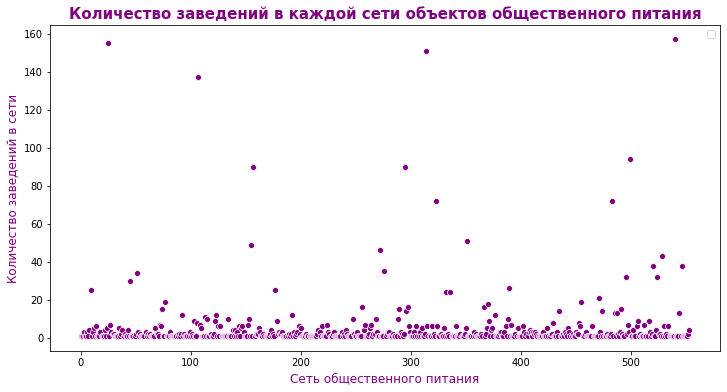

In [28]:
#рассморим на графике как распределено количество заведений в каждой сети и есть ли выбросы
plt.figure(figsize=(12,6))

sns.scatterplot(x=range(0,len(rest_data_chain['id'])),y=rest_data_chain['id'], color='purple')

plt.title("Количество заведений в каждой сети объектов общественного питания", fontsize = 15, fontweight="bold", color='purple')
plt.xlabel("Сеть общественного питания", fontsize = 12, fontweight=500, color='purple');
plt.ylabel('Количество заведений в сети', fontsize = 12, fontweight=500, color='purple');
plt.legend();

Выбросы явно присутствуют. Рассчитаем 99 перцентиль, чтобы исключить их.

In [29]:
np.percentile(rest_data_chain['id'], 99)

90.0

No handles with labels found to put in legend.


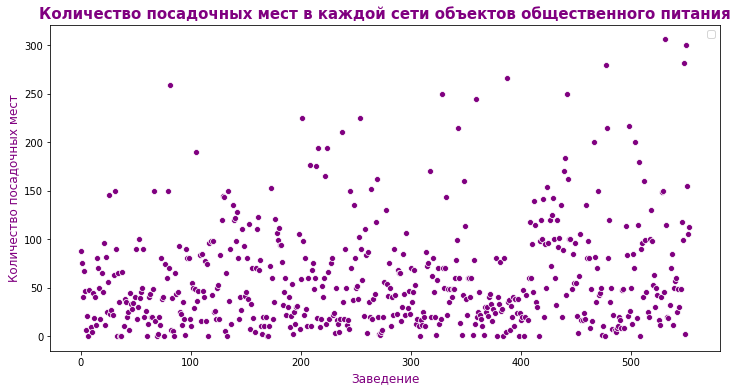

In [30]:
#рассморим на графике как распределено количество посадочных мест в каждой сети и есть ли выбросы
plt.figure(figsize=(12,6))

sns.scatterplot(x=range(0,len(rest_data_chain['number'])),y=rest_data_chain['number'], color='purple')

plt.title("Количество посадочных мест в каждой сети объектов общественного питания", 
          fontsize = 15, fontweight="bold", color='purple')
plt.xlabel("Заведение", fontsize = 12, fontweight=500, color='purple')
plt.ylabel('Количество посадочных мест', fontsize = 12, fontweight=500, color='purple')
plt.legend();

На графике видно, что в большинстве сетевых заведений не больше 100 посадочных мест, однако в целом ярко выраженных выбросов нет, поэтому оставим данные без изменений.

Рассчитаем коэффициент корреляции между количеством заведений в сети и количеством посадочных мест. Построим график совместного распределения с подбором регрессии. При анализе учтем ограничение в 90 заведений в каждой сети.

In [31]:
rest_data_chain_90 = rest_data_chain[rest_data_chain['id'] <= 90]

In [32]:
round(rest_data_chain_90['id'].corr(rest_data_chain_90['number']), 2)

-0.06

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


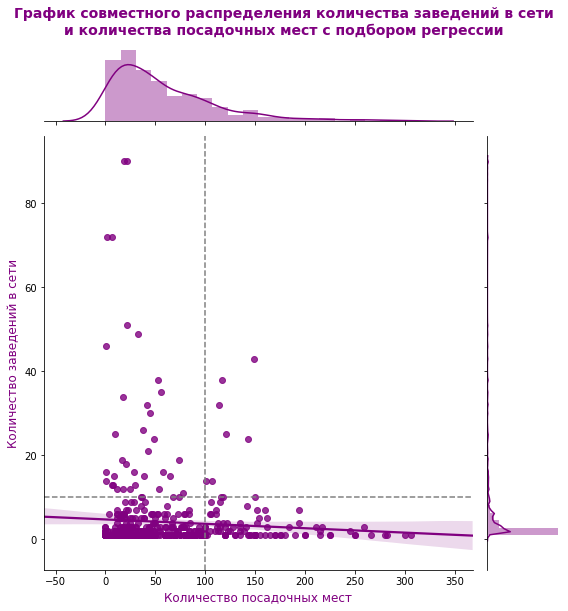

In [33]:
sns.jointplot("number", "id", data=rest_data_chain_90, kind='reg', size=8, color='purple').fig.suptitle(
'График совместного распределения количества заведений в сети\nи количества посадочных мест с подбором регрессии', 
    fontsize=14, fontweight="bold", color='purple', y=1.05) 
plt.axhline(y=10, color='grey', linestyle='--')
plt.axvline(x=100, color='grey', linestyle='--')
plt.xlabel('Количество посадочных мест', fontsize=12, color='purple')
plt.ylabel('Количество заведений в сети', fontsize=12, color='purple');

**Вывод**  
Видно, что данные сконцентрированы в начале графика и рассеиваются по мере удаленности от начала координат, однако корреляция между количеством точек в сети и количеством посадочных мест отсутствует. В целом в сетевых заведениях обычно не более 100 мест, а число точек редко превышает 10 заведений.

Отразим на графике **среднее количество посадочных мест для каждого вида объекта общественного питания**.

In [34]:
q_object_type.sort_values('number_of_seats', ascending=False)

,object_type,number_of_objects,number_of_seats
8,столовая,2587,130.25
7,ресторан,2285,96.83
1,буфет,585,51.13
0,бар,856,43.49
3,кафе,6099,39.72
6,предприятие быстрого обслуживания,1923,20.55
4,кафетерий,398,9.12
2,закусочная,360,7.61
5,магазин (отдел кулинарии),273,5.59


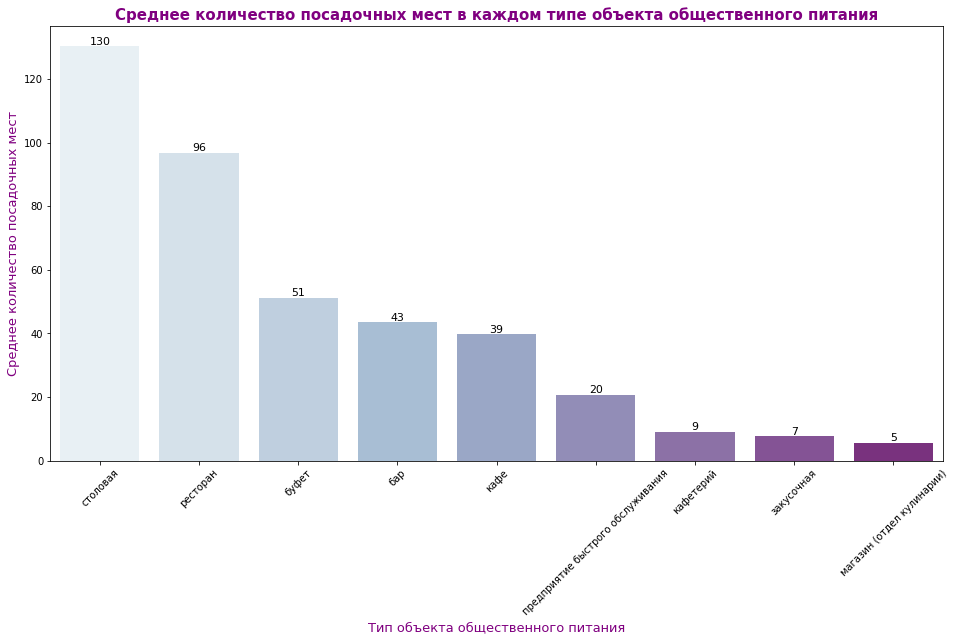

In [35]:
#отразим на графике среднее количество посадочных мест для каждого вида объекта общественного питания
sns_barplot('object_type', 'number_of_seats', q_object_type)

plt.title("Среднее количество посадочных мест в каждом типе объекта общественного питания", 
          fontsize = 15, fontweight="bold", color='purple')
plt.xlabel("Тип объекта общественного питания", fontsize = 13, fontweight=500,color='purple')
plt.ylabel('Среднее количество посадочных мест', fontsize = 13, fontweight=500,color='purple')
plt.show();

**Вывод**  
Больше всего посадочных мест в столовых. В целом можно отметить тенденцию, что большое количество посадочных мест компенсирует низкий коэффициент посадки и низкую оборачиваемость столов в заведениях общественного питания. Объекты с высокой обрачиваемостью (отделы кулинарии в магазинах, закусочные, кафетерии) не нуждаются в большом количестве мест, т.к. посетители проводят в таких местах горазд меньше времени, чем, например, в столовых, ресторанах или кафе.

Выделим в **отдельный столбец информацию об улице из столбца `address`**.

In [36]:
rest_address = rest_data.copy()
rest_address['street'] = rest_address['address'].str.extract(r'(?<=москва, )([^,]+)')
rest_address.head()

,id,object_name,chain,object_type,address,number,street
0,151635,сметана,нет,кафе,"город москва, улица егора абакумова, дом 9",48,улица егора абакумова
1,77874,родник,нет,кафе,"город москва, улица талалихина, дом 2/1, корпус 1",35,улица талалихина
2,24309,кафе академия,нет,кафе,"город москва, абельмановская улица, дом 6",95,абельмановская улица
3,21894,пиццетория,да,кафе,"город москва, абрамцевская улица, дом 1",40,абрамцевская улица
4,119365,кафе вишневая метель,нет,кафе,"город москва, абрамцевская улица, дом 9, корпус 1",50,абрамцевская улица


Определим **топ-10 улиц по количеству объектов общественного питания**.

In [37]:
rest_address['street'].value_counts().head(10)

город зеленоград          232
проспект мира             204
профсоюзная улица         182
ленинградский проспект    171
пресненская набережная    167
варшавское шоссе          161
ленинский проспект        147
поселение сосенское       138
проспект вернадского      132
кутузовский проспект      114
Name: street, dtype: int64

В топ-10 попали город Зеленоград и поселение Сосенское. Исключим их из рейтинга по следующим причинам:
1. Попали в рейтинг только потому, что при подсчете были учтены все заведения, расположенные в городе/поселении, а не на конкретной улице.
2. Проект дорогой, что скорее всего скажется на стоимости позиций меню, а размещение заведения на перефирии в труднодоступном месте не в самых дорогих районах Москвы ставит под вопрос его окупаемость. 

In [38]:
#исключаем из выборки Зеленоград и поселение Сосенское
rest_address = rest_address[~rest_address['address'].str.contains("зеленоград")]
rest_address = rest_address[~rest_address['address'].str.contains("поселение сосенское")]

Сформируем новый топ-10 

In [39]:
rest_address_group = rest_address.groupby('street').agg({'id':'count'}).reset_index()
rest_address_group.columns = ['street', 'number_of_objects']
top_10_streets = rest_address_group.sort_values('number_of_objects', ascending=False).head(10)

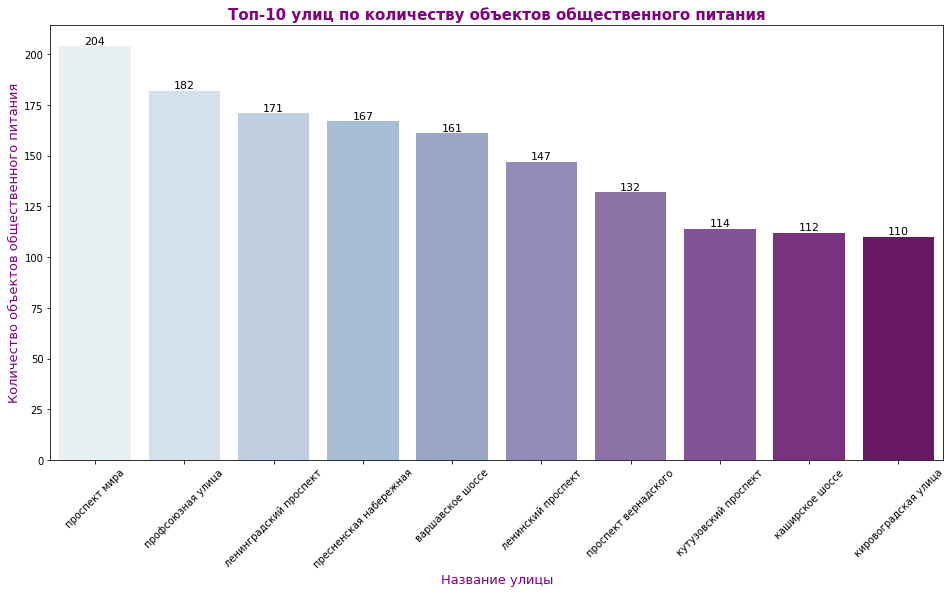

In [40]:
#отразим на графике топ-10 улиц по количеству объектов общественного питания
sns_barplot('street', 'number_of_objects', top_10_streets)

plt.title("Топ-10 улиц по количеству объектов общественного питания", 
          fontsize = 15, fontweight="bold", color='purple')
plt.xlabel("Название улицы", fontsize = 13, fontweight=500,color='purple')
plt.ylabel('Количество объектов общественного питания', fontsize = 13, fontweight=500,color='purple')
plt.show();

Импортируем файл с информацией о расположении улиц по районам Москвы.

In [41]:
spreadsheet_id = '1HGyDZnW6zr7gEsuGD8QmZ-meMtal0cu6A-BaLLHNd9Y'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
df = pd.read_csv(BytesIO(r.content))
df.fillna('').head()

,street,district_1,district_2,district_3,district_4,district_5,district_6,district_7,district_8,district_9
0,1-й ирининский переулок,МО Басманный,,,,,,,,
1,2-й ирининский переулок,МО Басманный,,,,,,,,
2,3-й ирининский переулок,МО Басманный,,,,,,,,
3,иркутская улица,МО Гольяново,,,,,,,,
4,1-й иртышский проезд,МО Гольяново,,,,,,,,


Дополним **топ-10 улиц информацией о районах**.

In [42]:
top_10_streets_full = top_10_streets[['street']].merge(df, on='street')
top_10_streets_full.fillna('')

,street,district_1,district_2,district_3,district_4,district_5,district_6,district_7,district_8,district_9
0,проспект мира,МО Мещанский,МО Алексеевский,МО Марьина Роща,МО Останкинский,МО Ростокино,МО Свиблово,МО Ярославский,,
1,профсоюзная улица,МО Академический,МО Коньково,МО Обручевский,МО Тёплый Стан,МО Черёмушки,МО Ясенево,,,
2,ленинградский проспект,МО Аэропорт,МО Беговой,МО Сокол,МО Хорошёвский,,,,,
3,пресненская набережная,МО Пресненский,,,,,,,,
4,варшавское шоссе,МО Донской,МО Нагатино-Садовники,МО Нагорный,МО Чертаново Северное,МО Чертаново Центральное,МО Чертаново Южное,МО Северное Бутово,МО Южное Бутово,городской округ Щербинка
5,ленинский проспект,МО Якиманка,МО Донской,МО Гагаринский,МО Ломоносовский,МО Обручевский,МО Тёплый Стан,МО Проспект Вернадского,МО Тропарёво-Никулино,
6,проспект вернадского,МО Гагаринский,МО Ломоносовский,МО Проспект Вернадского,МО Раменки,МО Тропарёво-Никулино,,,,
7,кутузовский проспект,МО Дорогомилово,МО Фили-Давыдково,,,,,,,
8,каширское шоссе,МО Москворечье-Сабурово,МО Нагатино-Садовники,МО Орехово-Борисово Северное,МО Орехово-Борисово Южное,,,,,
9,кировоградская улица,МО Чертаново Северное,МО Чертаново Центральное,МО Чертаново Южное,,,,,,


Посмотрим, как расположены эти улицы на карте Москвы

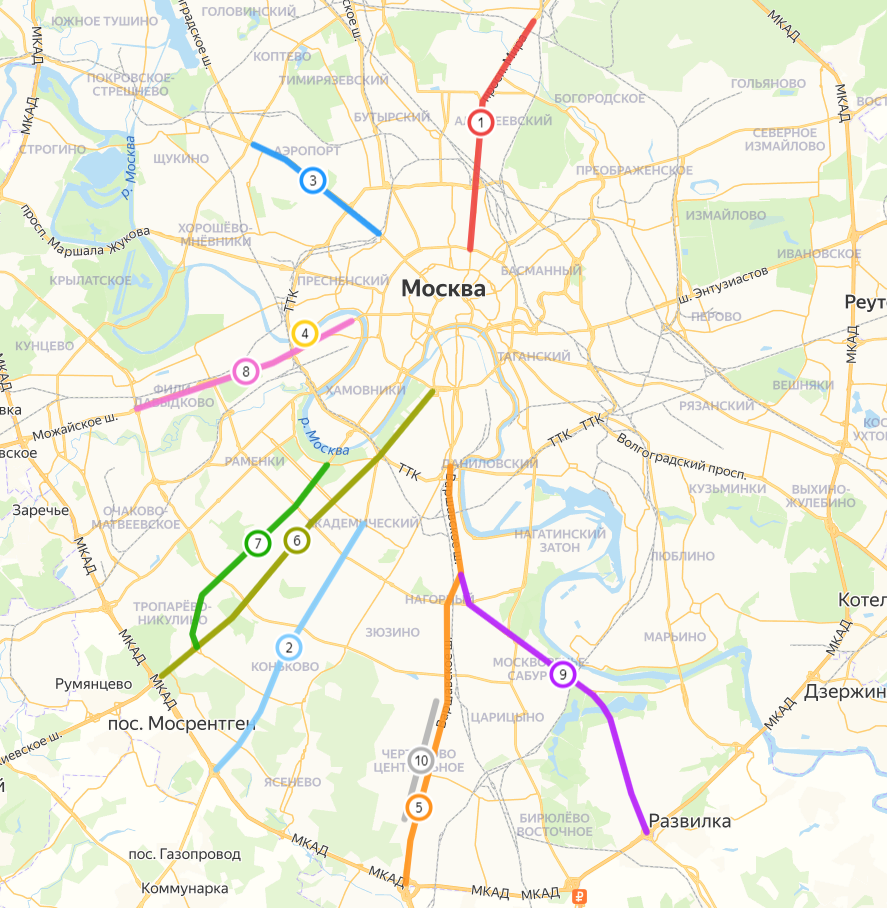

**Вывод**  
Все улицы, не считая Варшавского шоссе, расположены в пределах МКАД ближе к центру города, при чем больше в его западной части.  
Центр города это средоточие бизнес-центров, достопримечательностей, культурно-развлекательных заведений и торговых центров, способствующих скоплению людей и обеспечивающих приток клиентов. Протяженность улиц из топ-10 также объясняет большее количество заведений общественного питания, расположенных на них.

Найдем **число улиц с одним объектом общественного питания**.

In [43]:
rest_address_1 = rest_address_group[rest_address_group['number_of_objects'] == 1]

Дополним информацией о районах города

In [44]:
rest_address_1_full = rest_address_1[['street']].merge(df, on='street')
rest_address_1_full = rest_address_1_full.drop_duplicates(['street'])
print('Число улиц с одним объектом общественного питания:', len(rest_address_1_full))

Число улиц с одним объектом общественного питания: 536


Рассмотрим статистические характеристики полученного набора данных.

In [45]:
rest_address_1_full.describe()

,street,district_1,district_2,district_3,district_4,district_5,district_6,district_7,district_8,district_9
count,536,536,40,4,0,0,0,0,0,0
unique,536,102,26,4,0,0,0,0,0,0
top,новопресненский переулок,МО Таганский,МО Соколиная Гора,МО Коптево,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,27,4,1,NaN,NaN,NaN,NaN,NaN,NaN


**Вывод**  
Чаще всего улицы, на которых расположено только одно заведение общественного питания, находятся в Таганском районе, при этом такие улицы не отличаются большой протяженностью - обычно они ограничены одним районом города и никогда не проходят больше, чем через 3 района Москвы.

Рассмотрим **распределение количества посадочных мест для улиц с большим количеством объектов общественного питания**. 

In [46]:
top_10_streets['rank'] = top_10_streets['number_of_objects'].rank(ascending=False)

In [47]:
#создадим датафрейм по объектам общественного питания, расположенным на топ-10 улицах
top_objects = rest_address[rest_address['street'].isin(top_10_streets['street'].to_list())]
top_objects

,id,object_name,chain,object_type,address,number,street
151,155973,кафе андерсон,да,кафе,"город москва, варшавское шоссе, дом 2",150,варшавское шоссе
152,23618,кафе subway,да,кафе,"город москва, варшавское шоссе, дом 7, корпус 1",36,варшавское шоссе
153,155852,кафе ламаджо,нет,кафе,"город москва, варшавское шоссе, дом 29",30,варшавское шоссе
154,152556,шаурма в пите,нет,предприятие быстрого обслуживания,"город москва, варшавское шоссе, дом 72, корпус 2",0,варшавское шоссе
155,120658,выпечка,нет,кафетерий,"город москва, варшавское шоссе, дом 100",2,варшавское шоссе
...,...,...,...,...,...,...,...
15308,213629,додо пицца,да,кафе,"город москва, пресненская набережная, дом 12",25,пресненская набережная
15325,198436,милти,да,предприятие быстрого обслуживания,"город москва, ленинградский проспект, дом 80, корпус 17",0,ленинградский проспект
15347,222491,кальянная мята lounge,да,кафе,"город москва, профсоюзная улица, дом 142, корпус 1, строение 1",40,профсоюзная улица
15350,213061,мята,да,кафетерий,"город москва, каширское шоссе, дом 96, корпус 1",35,каширское шоссе


In [48]:
top_objects_street = top_objects.groupby('street').agg({'number':'mean'}).reset_index()

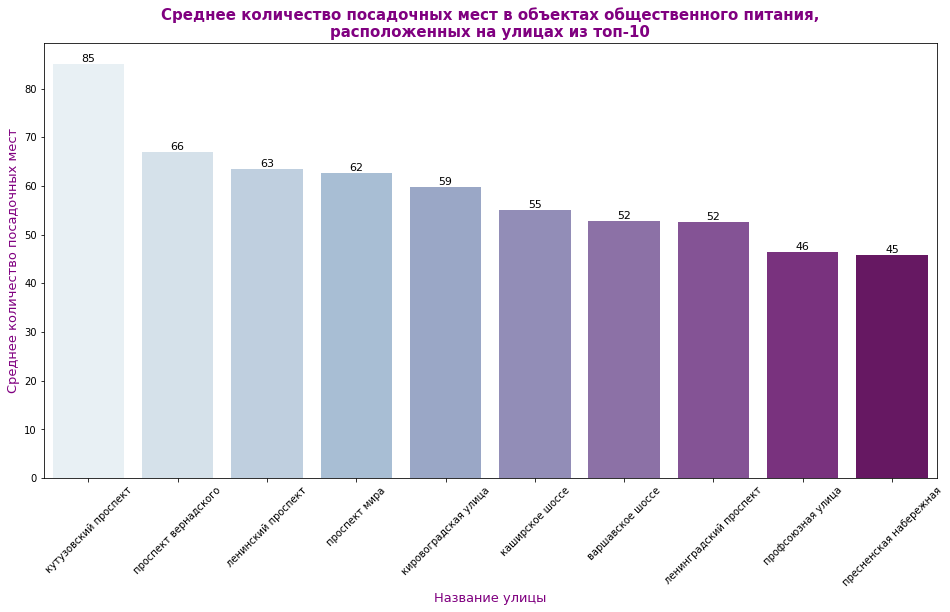

In [49]:
sns_barplot('street', 'number', top_objects_street)

plt.title("Cреднее количество посадочных мест в объектах общественного питания,\nрасположенных на улицах из топ-10", 
          fontsize = 15, fontweight="bold", color='purple')
plt.xlabel("Название улицы", fontsize = 13, fontweight=500,color='purple')
plt.ylabel('Среднее количество посадочных мест', fontsize = 13, fontweight=500,color='purple')
plt.show();

Кутузовский проспект явно выделяется на фоне остальных улиц. Проверим, нет ли выбросов.

In [50]:
#выделим 5 заведений с самым большим количеством посадочных мест
top_objects.sort_values('number', ascending=False).head()

,id,object_name,chain,object_type,address,number,street
12723,199696,arena by soho family,нет,бар,"город москва, кутузовский проспект, дом 36, строение 11",1700,кутузовский проспект
9064,19719,комбинат питания управление академсервис,нет,столовая,"город москва, проспект вернадского, дом 84, строение 1",1288,проспект вернадского
4480,27024,рум сервис,нет,ресторан,"город москва, кутузовский проспект, дом 2/1, строение 1",1200,кутузовский проспект
4110,29320,столовая,нет,столовая,"город москва, каширское шоссе, дом 31",680,каширское шоссе
7104,27033,банкетный,нет,ресторан,"город москва, ленинградский проспект, дом 31а, строение 1",625,ленинградский проспект


Есть 3 заведения с нетипично большим количеством посадочных мест и 2 из них находятся на кутузовском проспекте. Исключим эти выбросы из выборки.

In [51]:
top_objects_1200 = top_objects[top_objects['number'] < 1200]

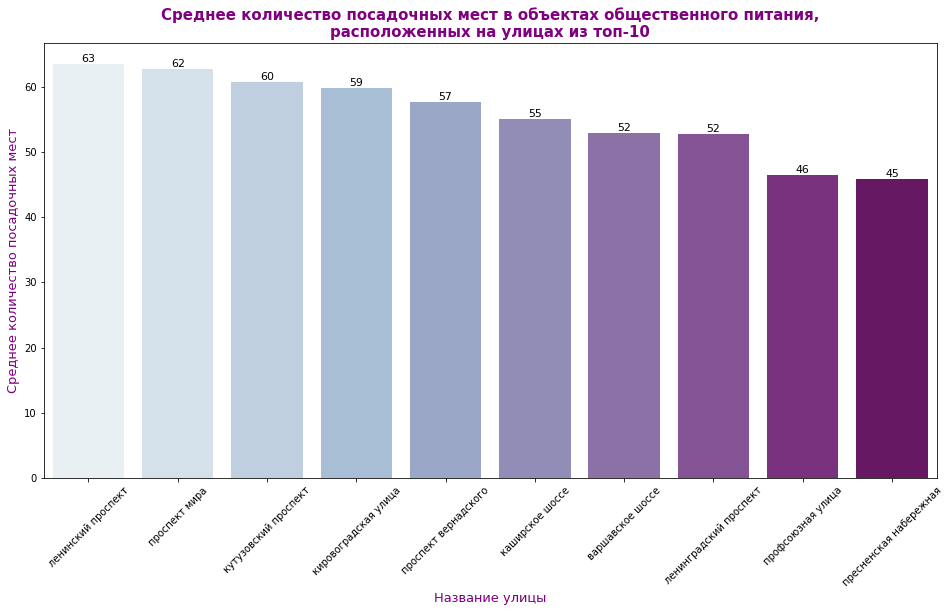

In [52]:
top_objects_1200_street = top_objects_1200.groupby('street').agg({'number':'mean'}).reset_index()

sns_barplot('street', 'number', top_objects_1200_street)

plt.title("Cреднее количество посадочных мест в объектах общественного питания,\nрасположенных на улицах из топ-10", 
          fontsize = 15, fontweight="bold", color='purple')
plt.xlabel("Название улицы", fontsize = 13, fontweight=500,color='purple')
plt.ylabel('Среднее количество посадочных мест', fontsize = 13, fontweight=500,color='purple')
plt.show();

**Вывод**  
В основном количество посадочных мест варьируется в диапазоне от 52 до 63, однако на Профсоюзной улице и Пресненской набережной расположены менее вместимые заведения. Наличие бизнес-центров и торгово-развлекательных центров с фудкортами снижают среднее количество посадочных мест за счет большего числа заведений общественного питания. Так на Пресненской набережной протяженностью всего 500 метров находится здание Москва-Сити, что объясняет наличие большого числа заведений, но с меньшей вместимостью.   
Что касается Профсоюзной улицы, то, возможно, здесь или расположено достаточно большое количество торговых и развлекательных центров или преобладают заведения небольшого формата: рестораны быстрого питания, бары, кафетерии.

<a name="h4"></a>
### 4. Общий вывод и рекомендации

В ходе исследования были получены следующие результаты:  
- Наибольшую долю рынка общественного питания Москвы занимают кафе (40%).
- Сетевая форма организации бизнеса наиболее характерна для предприятий быстрого обслуживания, однако в целом на рынке преобладают несетевые заведения. 
- Обычно сеть отдельного бренда общественного питания ограничена 10 заведениями, а количество посадочных мест не превышает 100.
- Низкий коэффициент оборачиваемости стола компенсируется большим числом посадочных мест.
- Концентрация бизнес-центров, достопримечательностей, торговых и развлекательных центров, а также протяженность самих улиц увеличивают число заведений общественного питания на них.  

С учетом данной информации при открытии нового объекта общественного питания необходимо обратить внимание на следующее:  
- Наиболее гибким форматом для воплощения нестандартных идей и оригинальных концпеций, по сравнению с другими типами объектов общественного питания, обладают кафе.  
- Принимая во внимание высокую стоимость реализуемого проекта, целесообразнее рассматривать центральную часть города. Особое внимание стоит уделить местам вблизи торгово-развлекательных центров и достопримечательностей, которые характеризуются повышенной проходимостью и концентрацией целевой аудитории. 
- Количество посадочных мест будет зависеть от оборачиваемости стола. Чем больше времени будет проводить отдельный гость в заведении, тем больше посадочных мест потребуется. Продолжительность посещения, в свою очередь, будет зависеть от сложности блюд и времени, необходимом на их приготовление. В среднем количество посадочных мест в заведениях общественного питания в центре Москвы варьируется от 52 до 63.
- В случае успешного запуска проекта в дальнейшем возможно развитие сети. Хорошим драйвером роста сети является франчайзинг.

Презентация: <https://drive.google.com/file/d/1k-s2TcU7zDf0LWIIB-W1LWDcP5HEwKyL/view?usp=sharing>